# Posterior inference on a birth-death model

In [1]:
from gcdyn import models, mutators, poisson, utils
from scipy.stats import gamma, lognorm, norm
from functools import partial
import numpy as np
import seaborn as sns
from mcmc import mh_tour
from jax import jit
from jax.config import config
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

## Set up truth

In [2]:
# (Deliberately avoiding rate parameters == constant 1, because a lot of bugs hide in this scenario)
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
    "extinct_sampling_probability": 0,
}

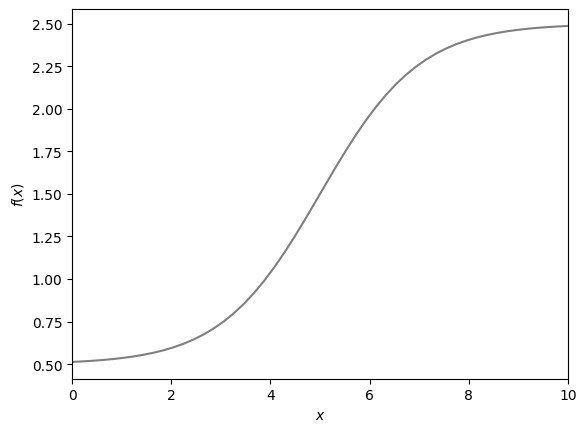

In [20]:
utils.plot_responses(true_parameters["birth_response"], x_range=(0, 10))

## Sample trees

In [3]:
seed = 10

PRESENT_TIME = 4

trees = utils.sample_trees(n=12, t=PRESENT_TIME, init_x=1, **true_parameters, seed=seed)

for tree in trees:
    if true_parameters["extinct_sampling_probability"] == 1:
        tree._pruned = True
    elif true_parameters["extinct_sampling_probability"] == 0:
        tree.prune()

print(
    "After pruning: average of",
    sum(len(list(tree.traverse())) for tree in trees) / len(trees),
    "nodes per tree, over",
    len(trees),
    "trees.",
)

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 131 times.
Success: average of 247.66666666666666 nodes per tree, over 12 trees.
After pruning: average of 111.83333333333333 nodes per tree, over 12 trees.


## Configure priors and proposals

In [4]:
mcmc_config = {
    "xscale": {
        "prior": gamma(a=2, scale=1),
        "proposal": lambda current: lognorm(scale=current, s=3),
    },
    "xshift": {
        "prior": norm(loc=5, scale=1),
        "proposal": lambda current: norm(loc=current, scale=2),
    },
    "yscale": {
        "prior": gamma(a=2, scale=1),
        "proposal": lambda current: lognorm(scale=current, s=1),
    },
    # "yshift": {
    #    "prior": gamma(a=1, scale=1 / 2),
    #    "proposal": lambda current: lognorm(scale=current, s=1),
    # },
    "death_rate_value": {
        "prior": gamma(a=3.5, scale=1 / 3),
        "proposal": lambda current: lognorm(scale=current, s=0.5),
    },
}

log_priors = {param: config["prior"].logpdf for param, config in mcmc_config.items()}

proposal_generators = {
    param: (lambda current: config["proposal"](current).rvs(size=1).item())
    for param, config in mcmc_config.items()
}
proposal_log_densities = {
    param: (lambda prop, cur: config["proposal"](cur).logpdf(prop))
    for param, config in mcmc_config.items()
}

# To compare to posterior later
prior_samples = {
    param: config["prior"].rvs(size=1000) for param, config in mcmc_config.items()
}

## Configure likelihood

In [5]:
log_likelihood_base = jit(
    partial(
        models.stadler_appx_log_likelihood,
        trees=trees,
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=true_parameters["extinct_sampling_probability"],
        present_time=PRESENT_TIME,
    )
)

# Trigger a JIT compile now
log_likelihood_base(
    birth_response=true_parameters["birth_response"],
    death_response=true_parameters["death_response"],
)

Array(-1383.03523618, dtype=float64)

In [6]:
def log_likelihood(death_rate_value, **birth_params):
    # def log_likelihood(**birth_params):
    return log_likelihood_base(
        birth_response=poisson.SigmoidResponse(
            **birth_params, yshift=true_parameters["birth_response"].yshift
        ),
        death_response=poisson.ConstantResponse(death_rate_value),
        # death_response=true_parameters["death_response"],
    )

## Run MCMC

In [7]:
posterior_samples, diagnostics = mh_tour(
    num_samples=2000,
    initial_value={
        "xscale": true_parameters["birth_response"].xscale,
        "xshift": true_parameters["birth_response"].xshift,
        "yscale": true_parameters["birth_response"].yscale,
        # "yshift": true_parameters["birth_response"].yshift,
        "death_rate_value": 2,
    },
    log_priors=log_priors,
    log_likelihood=log_likelihood,
    proposal_generators=proposal_generators,
    proposal_log_densities=proposal_log_densities,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

## Traceplots

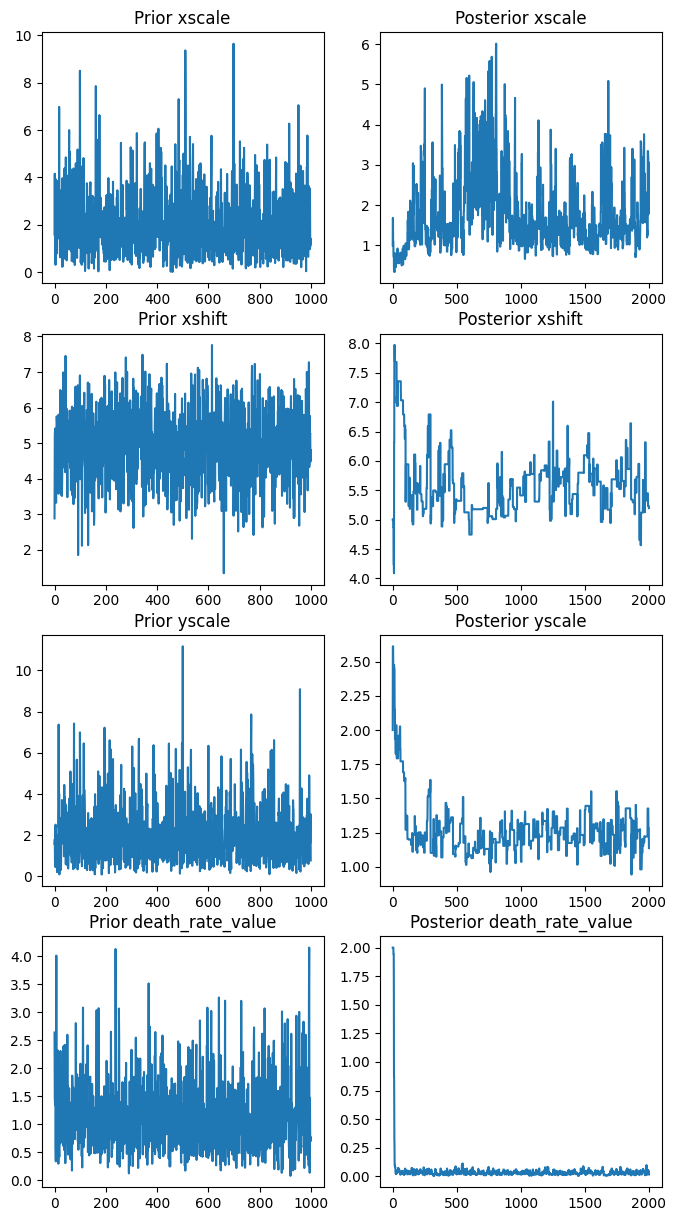

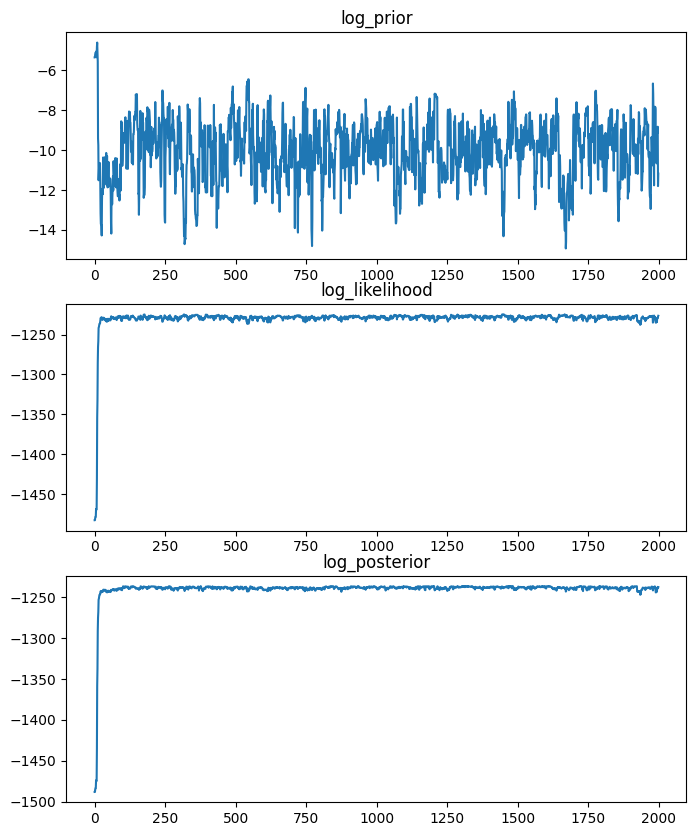

In [10]:
fig, axes = plt.subplots(len(posterior_samples), 2)
fig.set_figwidth(8)
fig.set_figheight(15)

for i, param in enumerate(posterior_samples):
    sns.lineplot(prior_samples[param], ax=axes[i, 0])
    axes[i, 0].set_title(f"Prior {param}")
    sns.lineplot(posterior_samples[param], ax=axes[i, 1])
    axes[i, 1].set_title(f"Posterior {param}")

plt.show()


fig, axes = plt.subplots(len(diagnostics), 1)
fig.set_figwidth(8)
fig.set_figheight(10)

for ax, diag in zip(axes, diagnostics):
    sns.lineplot(diagnostics[diag], ax=ax)
    ax.set_title(diag)

plt.show()

In [14]:
for param, chain in posterior_samples.items():
    acceptance_ratio = np.mean(chain[:-1] != chain[1:])
    print(f"Accepted {acceptance_ratio*100}% of {param} proposals")

Accepted 57.15% of xscale proposals
Accepted 12.2% of xshift proposals
Accepted 15.65% of yscale proposals
Accepted 72.89999999999999% of death_rate_value proposals


## Posterior samples and means

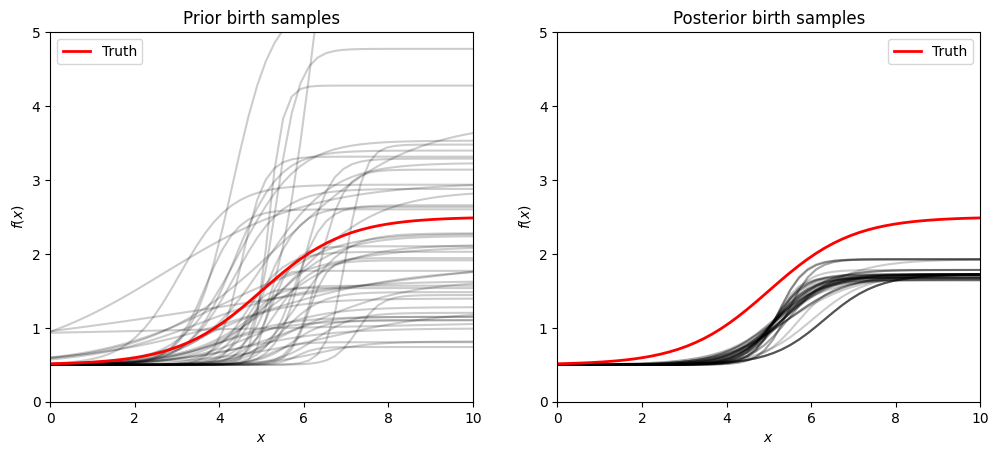

In [15]:
x_array = np.linspace(0, 10)

fig, axes = plt.subplots(1, 2)

for samples, ax in zip((prior_samples, posterior_samples), axes):
    birth_responses = []

    for i in range(len(samples["xscale"]) - 50, len(samples["xscale"])):
        response = poisson.SigmoidResponse(
            xscale=samples["xscale"][i].item(),
            xshift=samples["xshift"][i].item(),
            yscale=samples["yscale"][i].item(),
            yshift=true_parameters[
                "birth_response"
            ].yshift,  # samples["yshift"][i].item(),
        )

        birth_responses.append(response)

    for response in birth_responses:
        ax.plot(x_array, response.λ_phenotype(x_array), color="black", alpha=0.2)

    ax.plot(
        x_array,
        true_parameters["birth_response"].λ_phenotype(x_array),
        label="Truth",
        linewidth=2,
        color="red",
    )

    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.legend()

axes[0].set_title("Prior birth samples")
axes[1].set_title("Posterior birth samples")
fig.set_figwidth(12)
plt.show()

In [16]:
print("Prior means:", {param: round(s.mean(), 3) for param, s in prior_samples.items()})

print(
    "Posterior means:",
    {param: round(s.mean(), 3) for param, s in posterior_samples.items()},
)

Prior means: {'xscale': 1.997, 'xshift': 4.969, 'yscale': 1.988, 'death_rate_value': 1.17}
Posterior means: {'xscale': 1.755, 'xshift': 5.59, 'yscale': 1.266, 'death_rate_value': 0.042}


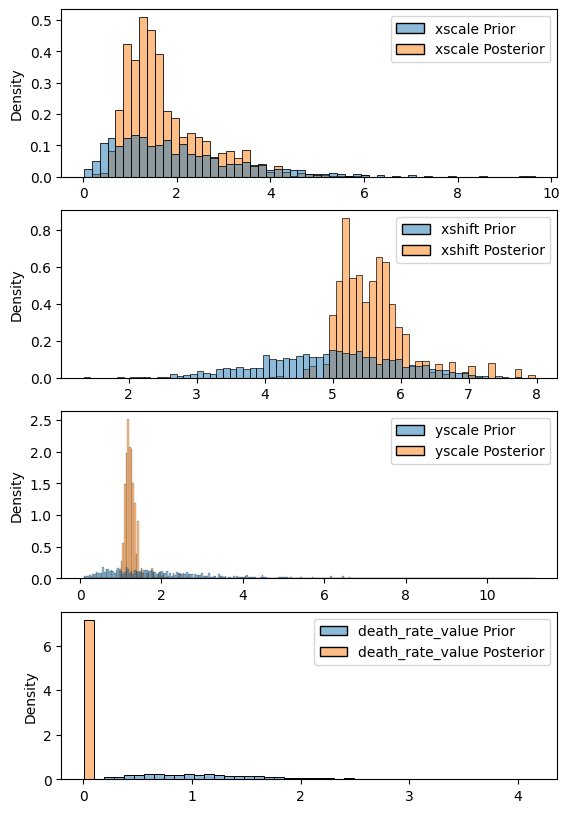

In [19]:
fig, axes = plt.subplots(len(posterior_samples), 1)
fig.set_figheight(10)

for ax, param in zip(axes, posterior_samples):
    s = {
        f"{param} Prior": prior_samples[param],
        f"{param} Posterior": posterior_samples[param],
    }

    sns.histplot(s, ax=ax, stat="density")